## Requirements
<!-- - pytorch 
    - Pytorch install: https://pytorch.org/get-started/locally/ 
- tqdm
- sklearn
- Huggingface Transformer: 
    - pip install transformers  -->
- **DATASET**:
    - https://github.com/BrownFortress/IntentSlotDatasets
    - We will use **ATIS** only
    
    

## Outline

#### Introduction
- sequence labelling (Slot filling)
- text classification (Intent classification)

#### Preparing text for NN
- word2id
- special tokens 
- Customize Dataset class

#### Split data in batches
- Usage of Dataloader class
- Padding sequences

#### Neural Networks in Pytorch
- Word embeddings
- Implementation of an LSTM
- Regularization techniques

#### Train and Test a Neural Network
- Optimizer
- Loss function
- Iteration over batches

#### Hugging face library
- Introduction and Usage
 
 
## References
- RNN: https://d2l.ai/chapter_recurrent-neural-networks/index.html 
- LSTM: https://d2l.ai/chapter_recurrent-modern/lstm.html
- GRU: https://d2l.ai/chapter_recurrent-modern/gru.html


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brownfortress/NLU-2024-labs/blob/main/labs/05_intent_and_slot_filling.ipynb)

# 1 Sequence Labeling,  Shallow Parsing and Text classification tasks

## 1.1 Sequence Labeling and Shallow parsing
Sequence labelling is to assign a label for each token. The task is formally defined as:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- defining a sequence of labels as $l = {l_1, l_2, ..., l_n}$
- compute the sequence $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

A particular case of sequence labelling is [Shallow Parsing](https://en.wikipedia.org/wiki/Shallow_parsing). The main difference from Sequence Labeling task is that Shallow Parsing performs __chunking__ -- segmentation of input sequence into constituents. Chunking is required to identify categories (or types) of *multi-word expressions*.

In this, we are going to see a particular case of shallow parsing task, which is named as Slot Filling (or Concept tagging). The **segmentation** part is represented with IOB tags and the **labeling** part are the concepts defined in the annotation schema of a corpus. \
\
An example is the following: 

| Slot Filling |  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output sequence: | O  | B-depart_date.month_name | B-depart_date.day_number | O | O    | O | O      |

## 1.2 Text classification
The text classification problem is defined  as follows:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- And a set of labels $L$ where $l \in L$
- estimate the label $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

In text classification, the label is given to the whole input sequence instead of at each element of the sequence (as in sequence labelling).

The text classification task that we are going to see in this laboratory is named as Intent Classification. The Intent is an additional component of the *semantic frame*. \
\
An example is the following:

| Intent Classification|  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output label: | flight     |


# 2 Dataset
The dataset that we are going to use is ATIS (Airline Travel Information Systems). It is composed of transcriptions of humans asking about flight information.  

## 2.2 Load the dataset
I have prepared a custom data structure for this dataset. The structure is the following:
```json
[
    {
    "utterance": "on april first i need a flight going from phoenix to san diego", 
    "slots": "O B-depart_date.month_name B-depart_date.day_number O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name", 
    "intent": "flight"
    },
    "..."
 ]
```

In [7]:
# If you are using Colab, run these commands
!wget -P dataset/ATIS https://raw.githubusercontent.com/BrownFortress/IntentSlotDatasets/main/ATIS/test.json
!wget -P dataset/ATIS https://raw.githubusercontent.com/BrownFortress/IntentSlotDatasets/main/ATIS/train.json
!wget https://raw.githubusercontent.com/BrownFortress/NLU-2024-Labs/main/labs/conll.py

In [8]:
# Global variables
import os
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [9]:
import json
from pprint import pprint

def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

tmp_train_raw = load_data(os.path.join('dataset','ATIS','train.json'))
test_raw = load_data(os.path.join('dataset','ATIS','test.json'))
print('Train samples:', len(tmp_train_raw))
print('Test samples:', len(test_raw))

pprint(tmp_train_raw[0])

Train samples: 4978
Test samples: 893
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


## 2.3 Create a dev set
In the original split the development set (dev set) is missing. To train and find the best hyperparameter of our network the dev set is fundamental. Thus, we have to create it starting from the **traning** set. The dev set is usually the 10% of the dataset. \
Possible sampling strategies:
* Take the last n elements of the training set.
* Do a random sampling from the training set.
* Do a stratified sampling from the training set using one or more criteria. (The best way)
    * For further details look [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [10]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# First we get the 10% of the training set, then we compute the percentage of these examples 

portion = 0.10

intents = [x['intent'] for x in tmp_train_raw] # We stratify on intents
count_y = Counter(intents)

labels = []
inputs = []
mini_train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # If some intents occurs only once, we put them in training
        inputs.append(tmp_train_raw[id_y])
        labels.append(y)
    else:
        mini_train.append(tmp_train_raw[id_y])
# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(inputs, labels, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=labels)
X_train.extend(mini_train)
train_raw = X_train
dev_raw = X_dev

y_test = [x['intent'] for x in test_raw]

# Intent distributions
print('Train:')
pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
print('Test:') 
pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw))
print('DEV size:', len(dev_raw))
print('TEST size:', len(test_raw))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.2,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.6,
 'airfare': 8.4,
 'airline': 3.2,
 'airport': 0.4,
 'capacity': 0.4,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.4,
 'ground_service': 5.0,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 'flight+airline

## 2.3 Convert words to numbers (word2id)
Neural Networks in Pytorch, as in other libraries, work with numbers and vectors.
<br><br>

**Exercise 1** *(10 minutes)*
* Create a dictionary that maps the words and labels in the training set to unique  integers $\geq$ 0, called indexes.
    That is:
    - One dictionary for mapping words to ids (w2id)
    - One dictionary for mapping slot labels to ids (slot2id)
    - One dictionary for mapping intent labels to ids (intent2id)

* With w2id map the sentence in `sent` into the computed indexes.

***Example:***
```python
dictionary = {"from": 2, "Boston":88, "to":105, "Tokyo":42}
sent = "from Boston to Tokyo" 
# Output:
[2,88,105,42]
```

We will see later how to convert these indexes into vectors (aka embeddings).

*Add special tokens "pad" and "unk"*


In [11]:
from collections import Counter

w2id = {'pad':PAD_TOKEN}                            # Pad tokens is 0 so the index count should start from 1
slot2id = {'pad':PAD_TOKEN}                         # Pad tokens is 0 so the index count should start from 1
intent2id = {}

# Map the words only from the train set
# Map slot and intent labels of train, dev and test set. 'unk' is not needed.
sent = 'I wanna a flight from Toronto to Kuala Lumpur'

mapping = []                                        # convert the sent into indexes using w2id 
print(mapping)


print('# Vocab:', len(w2id)-2)                      # we remove pad and unk from the count
print('# Slots:', len(slot2id)-1)
print('# Intent:', len(intent2id))

[]
# Vocab: -1
# Slots: 0
# Intent: 0


## 2.4 Lang class
Later we will need to convert those numbers in the original form, so we need to invert those dictionaries. We create a class named as Lang just for convenience.

In [12]:
from collections import Counter
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [13]:
words = sum([x['utterance'].split() for x in train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
corpus = train_raw + dev_raw + test_raw # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots = set(sum([line['slots'].split() for line in corpus],[]))
intents = set([line['intent'] for line in corpus])

lang = Lang(words, intents, slots, cutoff=0)

## 2.5 Customize the Dataset class
In Pytorch the Dataset class helps you in handeling the dataset. The mandatory methods are ```__init__, __len__ and __getitem__```. <br>
You can find more details here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

In [14]:
import torch
import torch.utils.data as data

class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [15]:
# Create our datasets
train_dataset = IntentsAndSlots(train_raw, lang)
dev_dataset = IntentsAndSlots(dev_raw, lang)
test_dataset = IntentsAndSlots(test_raw, lang)

# 3 Batches
Batches are used to handle large datasets in the memory. Since the whole dataset cannot fit in GPU memories, we randomly shuffle the dataset and we split it in small batches that will be processed one at a time.
## 3.1 Padding
Padding is a strategy to fit sequences of different lengths into a matrix. For instance:

| Right padding|   |    |   |  |  |  |  
|---|----|---|---|---|------|---|
| I | saw| a | unk | with | a | telescope | 
| book | me | a | flight | [pad] | [pad] | [pad] | 

| Left padding|   |    |   |  |  |  |  
|---|----|---|---|---|------|---|
| I | saw| a | unk | with | a | telescope | 
| [pad] | [pad] | [pad] | book | me | a | flight | 



**Exercise 2** *(5 minutes)* <br> 
Write a function that adds padding on the right. (No need to convert the sentences to numbers)

In [16]:
# split them by white space
sequences = ['I saw a man with a telescope', 
             'book me a flight', 
             'I want to see the flights from Milan to Ibiza']

### Dataloader
To split the dataset into batches and add padding we will use the DataLoader class. 
```python
DataLoader(Dataset, batch_size=N, collate_fn={custom function}, shuffle=True)
```
*collate_fn* is used to shape the output batch.

In [17]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
        
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our selected device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

# Dataloader instantiations
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# 4 Define a neural network in Pytorch
In PyTorch the definition of a neural network is quite flexible. In ```__init__``` the layer that is going to be used are instantiated. In ```forward```, the architecture of the neural network is defined. Here you can find all the layers provided by Pytorch https://pytorch.org/docs/stable/nn.html while here you can find the recurrent layers https://pytorch.org/docs/stable/nn.html#recurrent-layers. 

<br><br>
**pack_padded_sequence** and **pad_packed_sequences** respectively compress and uncompress sequences to remove the padding embeddings from the computation, reducing the computational cost and, therefore, the CO2 emissions.
 ![](https://i.stack.imgur.com/LPHAs.jpg)





In [18]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (output size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False, batch_first=True)    
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        # Dropout layer How/Where do we apply it?
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy(), batch_first=True)
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
       
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        
        # Is this another possible way to get the last hiddent state? (Why?)
        # utt_encoded.permute(1,0,2)[-1]
        
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: batch_size, seq_len, classes 
        slots = slots.permute(0,2,1) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

## 3.1 Function to randomly initialize the weights
This is a generic function that randomly initialize the parameters of RNN networks and linear layers. To dig deep in to this I would suggest you to look at here: https://pytorch.org/docs/master/nn.init.html \
\
*Note: In Pytorch every parameter of the network has a proper name like weight_ih, weight_hh etc.*

In [19]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

## 3.2 Training set up
We initialize the model and we select the hyperparameters of the neural network. Futhermore, we initialize the optimizer and we select the loss function.
- You can find further optimization algorithms here: https://pytorch.org/docs/stable/optim.html
- and further loss functions here: https://pytorch.org/docs/stable/nn.html#loss-functions

In [20]:
import torch.optim as optim

hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang.slot2id)
out_int = len(lang.intent2id)
vocab_len = len(lang.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

### Train Loop and Evaluation Loop
We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**.

<br>

In the literature, the Intent Classification task is evaluated using accuracy as a metric. The Slot filling task is evaluated using the *conll script* which computes the performance at the chunk level and the F1 score is usually reported. 

In [21]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop(data, optimizer, criterion_slots, criterion_intents, model, clip=5):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predicts a class that is not in REF
        print("Warning:", ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        results = {"total":{"f":0}}
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


## 3.3 Train a neural network
We train a neural network iterating several times over the training set. 
* **epochs**: number of times in which the whole training set is seen by the network
* **early stopping**: keeps controlled the performance of the model on the dev set and interrupts the training when the performance is getting worse
    * **patience**: wait for a number of step before interrupting the training, even though the performance is getting worse. 

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm
n_epochs = 200
patience = 3
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0
for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader, optimizer, criterion_slots, 
                      criterion_intents, model, clip=clip)
    if x % 5 == 0: # We check the performance every 5 epochs
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, 
                                                      criterion_intents, model, lang)
        losses_dev.append(np.asarray(loss_dev).mean())
        
        f1 = results_dev['total']['f']
        # For decreasing the patience you can also use the average between slot f1 and intent accuracy
        if f1 > best_f1:
            best_f1 = f1
            # Here you should save the model
            patience = 3
        else:
            patience -= 1
        if patience <= 0: # Early stopping with patience
            break # Not nice but it keeps the code clean

results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, 
                                         criterion_intents, model, lang)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])


/home/bonnie/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
 15%|█▍        | 29/199 [00:57<05:35,  1.97s/it]


KeyboardInterrupt: 

### Saving the model
To save the model you have to save:
- The weights of the model
- The computed vocabularies (w2id, slot2id, intent2id)
- The optimizer (optionally, only if you want to continue with the training)

In [ ]:
# PATH = os.path.join("bin", model_name)
# saving_object = {"epoch": x, 
#                  "model": model.state_dict(), 
#                  "optimizer": optimizer.state_dict(), 
#                  "w2id": w2id, 
#                  "slot2id": slot2id, 
#                  "intent2id": intent2id}
# torch.save(saving_object, PATH)

### Plot of the train and valid losses
One of the techniques for debugging a neural network is to check the plot of the loss. If the loss goes smoothly down then the network works correctly, otherwise a deeper analysis is needed. Furthermore, this plot can be useful for deciding the learning rate and the optimizer algorithm.

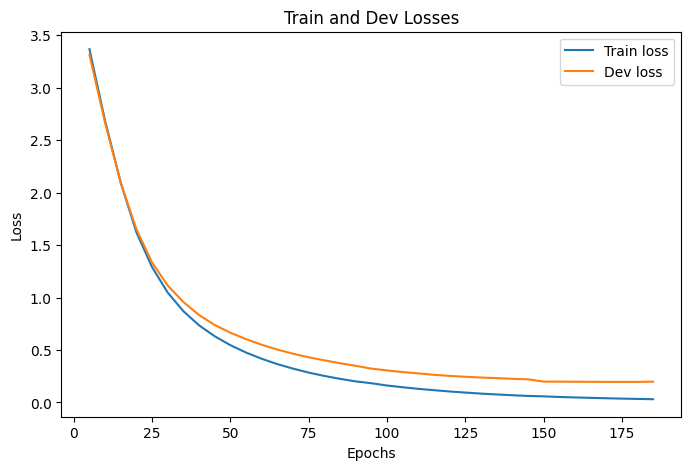

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs, losses_train, label='Train loss')
plt.plot(sampled_epochs, losses_dev, label='Dev loss')
plt.legend()
plt.show()

### Multiple runs
To have reliable results on small corpora we have to train and test the model from scratch for several times. At the end, we average the results and we compute the standard deviation.

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient


out_slot = len(lang.slot2id)
out_int = len(lang.intent2id)
vocab_len = len(lang.word2id)

n_epochs = 200
runs = 5

slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    model = ModelIAS(hid_size, out_slot, out_int, emb_size, 
                     vocab_len, pad_index=PAD_TOKEN).to(device)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()
    

    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in range(1,n_epochs):
        loss = train_loop(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patient
                break # Not nice but it keeps the code clean

    results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, 
                                             criterion_intents, model, lang)
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|██████████| 5/5 [10:17<00:00, 123.54s/it]

Slot F1 0.923 +- 0.002
Intent Acc 0.936 +- 0.002


 ![](https://huggingface.co/front/assets/huggingface_logo-noborder.svg)
# Hugging Face
Hugging Face is a library that allows you to use pretrained models in an easy way. This means that you do not need to implement an architecture and train it from scratch. Hugging Face is based on a community where people share trained models and code.
<br/><br/>
In Hugging Face there are many different models (https://huggingface.co/models) that you can import and each of them has its own input and output shapes. However, Transformer-based models are usually composed of two parts: 
- **Tokenizer**
- **Architecture/Pretrained model**

In [ ]:
# BERT model script from: huggingface.co
from transformers import BertTokenizer, BertModel
from pprint import pprint

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Download the tokenizer
model = BertModel.from_pretrained("bert-base-uncased") # Download the model

inputs = tokenizer(["I saw a man with a telescope", "StarLord was here",  "I didn't"], return_tensors="pt", padding=True)
pprint(inputs)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0]]),
 'input_ids': tensor([[  101,  1045,  2387,  1037,  2158,  2007,  1037, 12772,   102],
        [  101,  2732, 19980,  2001,  2182,   102,     0,     0,     0],
        [  101,  1045,  2134,  1005,  1056,   102,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [ ]:
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

##  Byte pair encoding
The tricky part of using Transformer-based model is the tokenizer which is based on byte pair encoding algorithm. Indeed, the **tokenizers** used by Transformer-based models are different from those we have seen in the lab. While for instance Spacy's tokenizer is rule-based and splits the text looking at the punctuation, the goal of Transformer tokenizers is to reduce the vocabulary length by splitting words into subwords. A thoroughly explanation of such these tokenizers can be found here: https://huggingface.co/docs/transformers/tokenizer_summary  

In [ ]:
print(inputs["input_ids"][0])
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][1]))

# Mandatory Exam Exercise

## Part 1 (4 points)
As for LM project, you have to apply these two modifications incrementally. Also in this case you may have to play with the hyperparameters and optimizers to improve the performance. 

Modify the baseline architecture Model IAS by:
- Adding bidirectionality
- Adding dropout layer

**Intent classification**: accuracy <br>
**Slot filling**: F1 score with conll

***Dataset to use: ATIS***

## Part 2 (11 points)

Adapt the code to fine-tune a pre-trained BERT model using a multi-task learning setting on intent classification and slot filling. 
You can refer to this paper to have a better understanding of how to implement this: https://arxiv.org/abs/1902.10909. In this, one of the challenges of this is to handle the sub-tokenization issue.

*Note*: The fine-tuning process is to further train on a specific task/s a model that has been pre-trained on a different (potentially unrelated) task/s.


The models that you can experiment with are [*BERT-base* or *BERT-large*](https://huggingface.co/google-bert/bert-base-uncased). 

**Intent classification**: accuracy <br>
**Slot filling**: F1 score with conll

***Dataset to use: ATIS***
